# Road Detection from Aerial Images


## 1. Environment Setup

In [7]:
# Import required packages
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# Import custom modules
from src.data import RoadsDataset, get_training_augmentation, get_validation_augmentation, get_preprocessing, calculate_class_weights
from src.losses import dice_coefficient, iou_score
from src.training import train_model
from src.visualization import visualize, plot_training_history, plot_predictions_with_raw_images
from src.utils import set_seed, create_directories

# Set up device (CPU, MPS or CUDA)
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
set_seed(42)

Using device: mps


## 2. Data Loading and Preparation

In [2]:
# Define data directory
DATA_DIR = '../dataset/'

# Load and prepare metadata
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
print(f"Training samples: {len(train_df)}, Validation samples: {len(valid_df)}")

Training samples: 5603, Validation samples: 623


## 3. Creating Simple Dataset (No Augmentation)

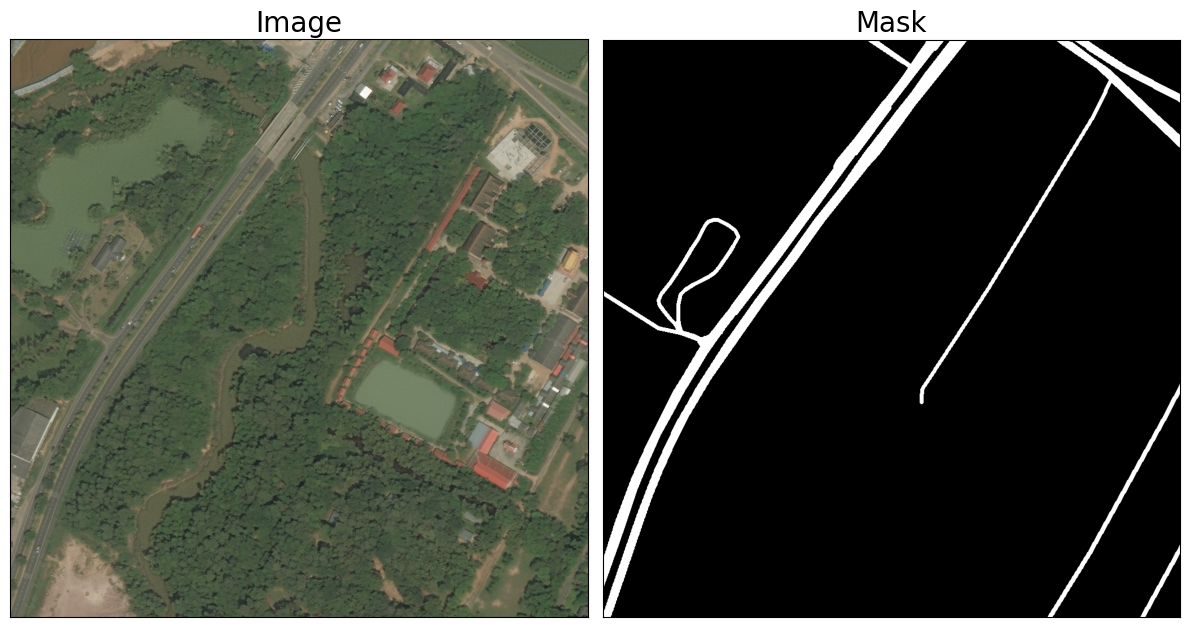

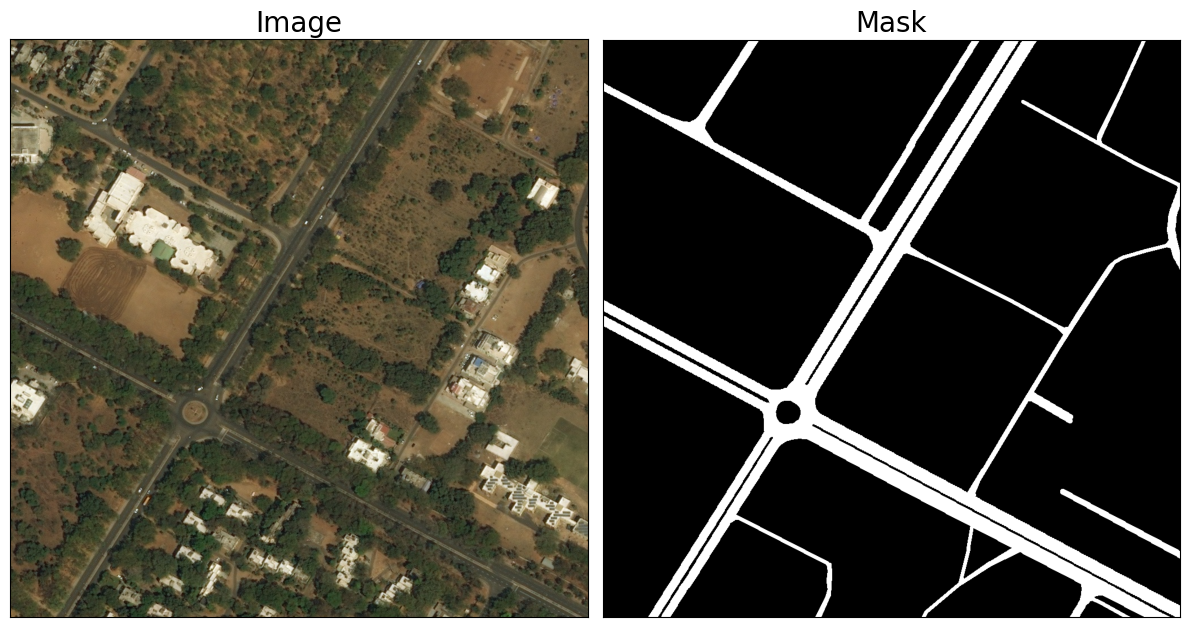

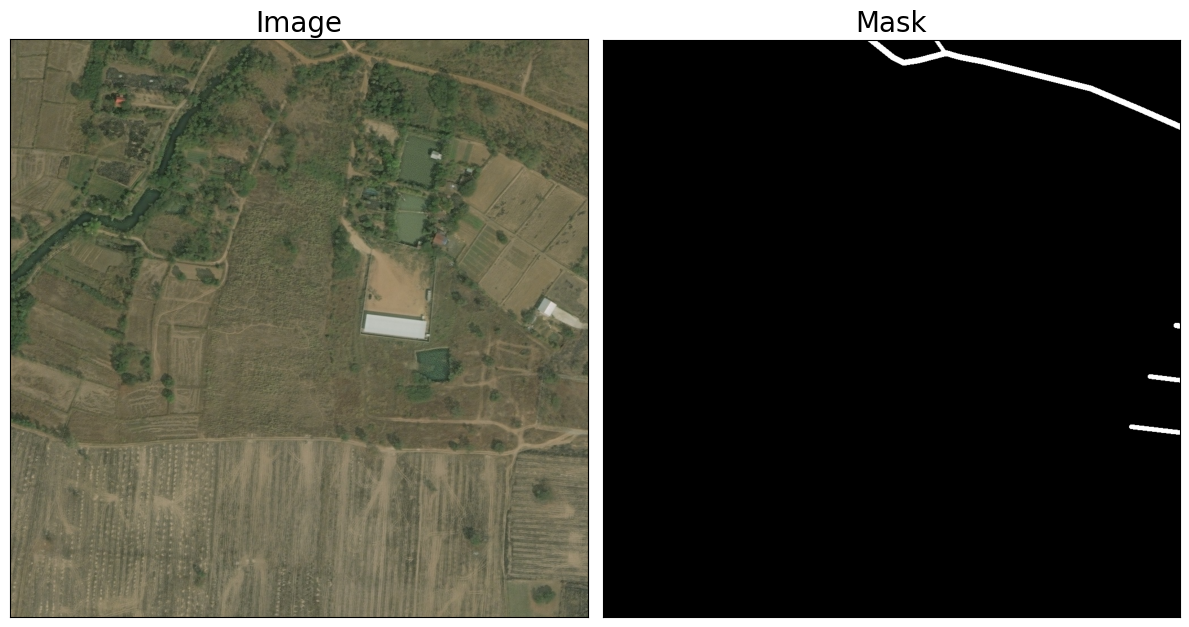

In [25]:
# Create a simple dataset for visualization without augmentation or preprocessing
simple_dataset = RoadsDataset(
    train_df.iloc[:10],  # Using only a small subset for visualization
    augmentation=None,
    preprocessing=None
)

# Visualize a few examples
for i in range(3):
    image, mask = simple_dataset[i]
    visualize(
        image=image,
        mask=mask
    )

## 4. Data Augmentation Demo

/Users/azizbek/Documents/Projects/RoadDetection/src/data.py:67: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=height, width=width, always_apply=True),
/Users/azizbek/Documents/Projects/RoadDetection/src/data.py:81: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=1.0),
/Users/azizbek/Documents/Projects/RoadDetection/src/data.py:83: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),


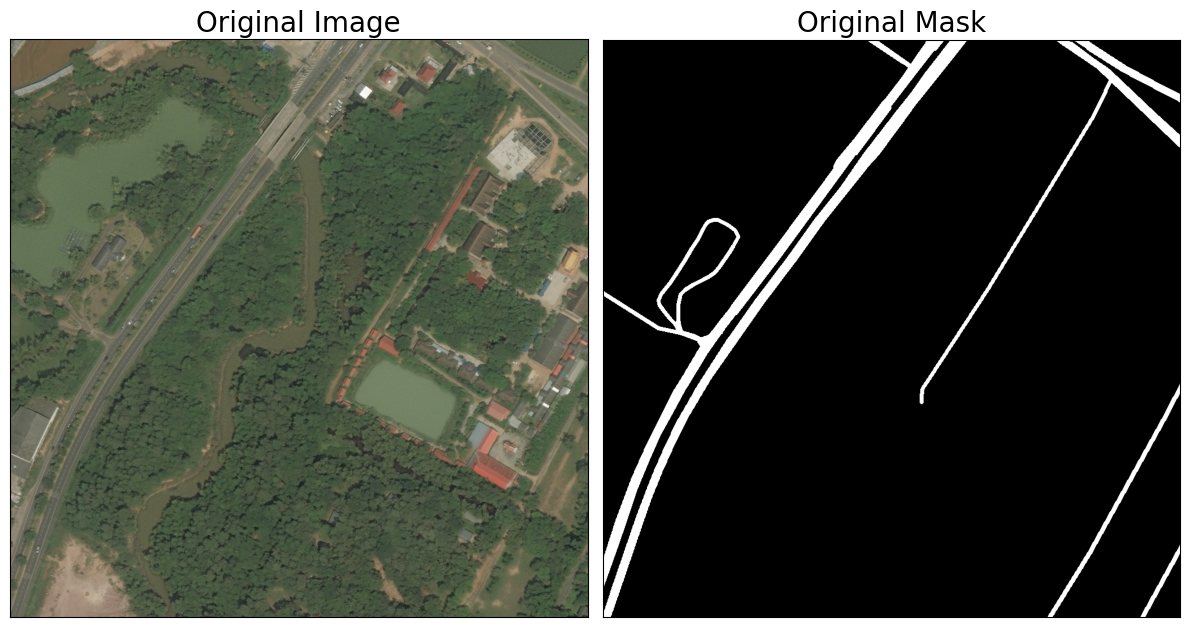

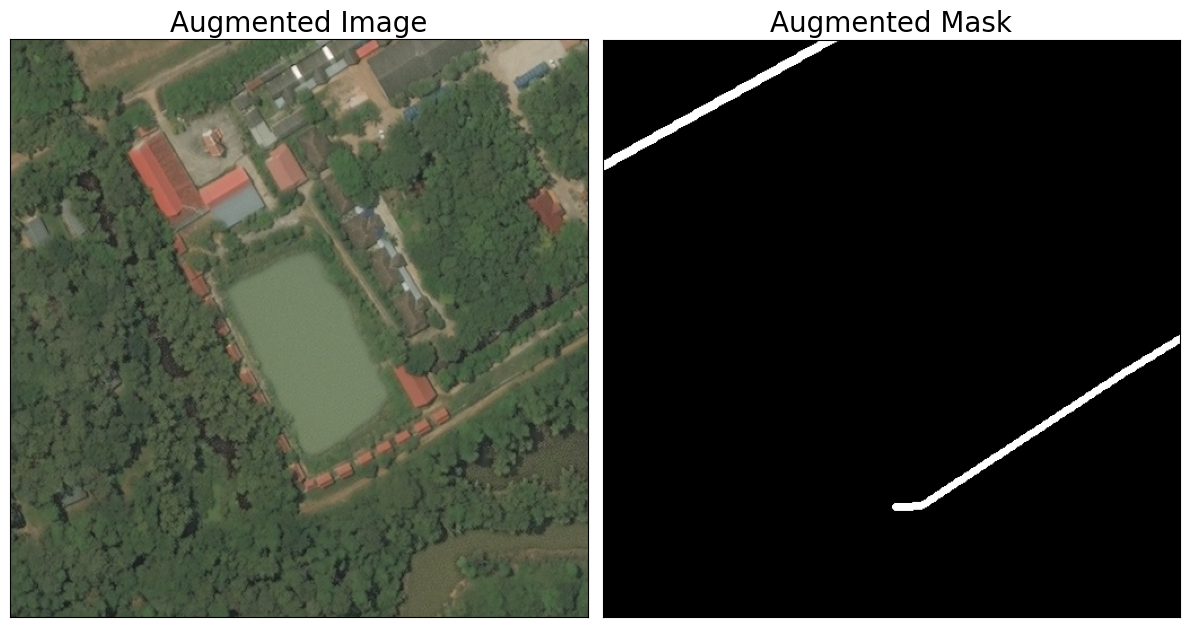

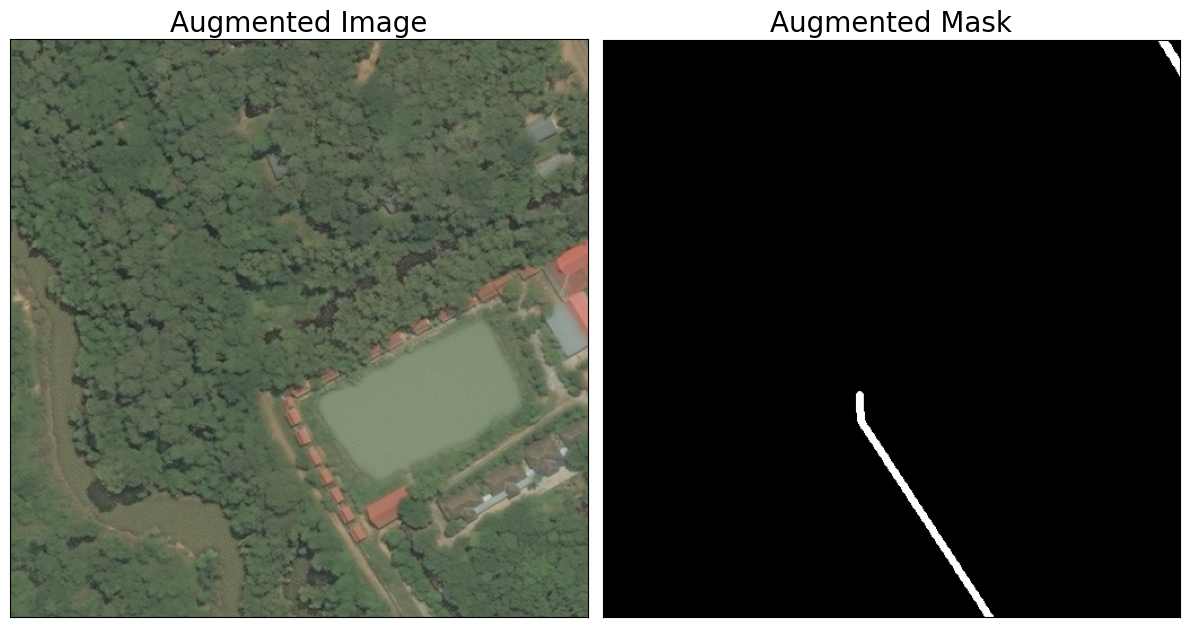

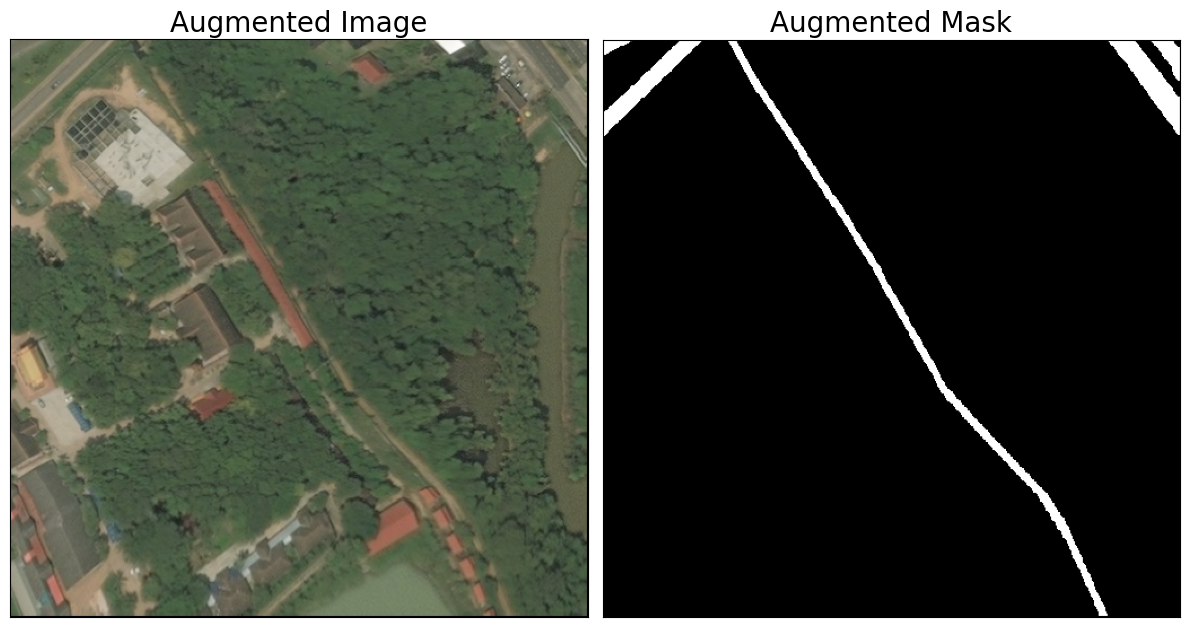

In [26]:
# Create a dataset with augmentation for demonstration
aug_dataset = RoadsDataset(
    train_df.iloc[:10],  # Using only a small subset for visualization
    augmentation=get_training_augmentation(height=512, width=512),
    preprocessing=None
)

# Visualize augmentation examples
image, mask = simple_dataset[0]  # Original image
visualize(original_image=image, original_mask=mask)

# Show 3 different augmentations of the same image
for i in range(3):
    aug_image, aug_mask = aug_dataset[0]  # Same index, different augmentation each time
    visualize(augmented_image=aug_image, augmented_mask=aug_mask)

## 5. Creating Training and Validation Datasets

In [27]:
# Create the training dataset with augmentation and preprocessing
train_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(height=512, width=512),
    preprocessing=get_preprocessing()
)

# Create the validation dataset with preprocessing but no augmentation
valid_dataset = RoadsDataset(
    valid_df,
    augmentation=get_validation_augmentation(height=512, width=512),
    preprocessing=get_preprocessing()
)

# Create data loaders
batch_size = 4  # Adjust based on your MacBook's memory capacity

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,  # Adjust based on CPU cores available
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/Users/azizbek/Documents/Projects/RoadDetection/src/data.py:67: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=height, width=width, always_apply=True),
/Users/azizbek/Documents/Projects/RoadDetection/src/data.py:81: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=1.0),
/Users/azizbek/Documents/Projects/RoadDetection/src/data.py:83: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),


## 6. Calculating Class Weights (Optional)

In [9]:
# Create a dataset without preprocessing for calculating class weights
weight_dataset = RoadsDataset(
    train_df.iloc[:500],  # Using a subset for efficiency
    augmentation=None,
    preprocessing=None
)

# Calculate class weights
class_weights = calculate_class_weights(weight_dataset)
print(f"Class weights: {class_weights}")

Class weights: tensor([0.0433, 0.9567])


## 7. Model Initialization

In [4]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

model = model.to(device)


print(f"Model: {model.__class__.__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Model: DeepLabV3Plus
Total parameters: 26677585


## 8. Loss Function and Optimizer

In [34]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1.0, bce_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        # Binary Cross Entropy loss
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets)

        # Dice Loss
        inputs_sigmoid = torch.sigmoid(inputs)

        # Flatten
        inputs_sigmoid = inputs_sigmoid.view(-1)
        targets = targets.view(-1)

        # Dice coefficient
        intersection = (inputs_sigmoid * targets).sum()
        dice_score = (2. * intersection + 1) / (inputs_sigmoid.sum() + targets.sum() + 1)
        dice_loss = 1 - dice_score

        # Combined loss
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

criterion = CombinedLoss(dice_weight=1.0, bce_weight=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=30,
    pct_start=0.1  # 10% of training for warm-up
)

## 9. Training the Model

In [36]:
create_directories('./models')

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    loss_fn=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    device=device,
    patience=3,
    checkpoint_path='./models/best_unet_resnet34.pth' #Forgot to update this part of the code (model name should be DeepLabV3Plus)
)

Training on mps


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.55it/s, dice=0.501, iou=0.334, loss=0.667]  


Epoch 1/20
Train Loss: 0.8881, Dice: 0.4590, IoU: 0.3110
Val Loss: 0.5704, Dice: 0.6139, IoU: 0.4532
Learning Rate: 0.00004000
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.61it/s, dice=0.585, iou=0.413, loss=0.529] 


Epoch 2/20
Train Loss: 0.5394, Dice: 0.6070, IoU: 0.4442
Val Loss: 0.4483, Dice: 0.6644, IoU: 0.5073
Learning Rate: 0.00004000
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:44<00:00,  3.54it/s, dice=0.567, iou=0.396, loss=0.549]  


Epoch 3/20
Train Loss: 0.4724, Dice: 0.6433, IoU: 0.4827
Val Loss: 0.4227, Dice: 0.6744, IoU: 0.5198
Learning Rate: 0.00004000
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:44<00:00,  3.54it/s, dice=0.624, iou=0.453, loss=0.459]   


Epoch 4/20
Train Loss: 0.4443, Dice: 0.6606, IoU: 0.5014
Val Loss: 0.4478, Dice: 0.6457, IoU: 0.4918
Learning Rate: 0.00004000


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.55it/s, dice=0.588, iou=0.416, loss=0.522]  


Epoch 5/20
Train Loss: 0.4271, Dice: 0.6730, IoU: 0.5151
Val Loss: 0.3997, Dice: 0.6917, IoU: 0.5397
Learning Rate: 0.00004000
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.59it/s, dice=0.59, iou=0.418, loss=0.513]   


Epoch 6/20
Train Loss: 0.4229, Dice: 0.6748, IoU: 0.5178
Val Loss: 0.3972, Dice: 0.6905, IoU: 0.5388
Learning Rate: 0.00004000


Validation: 100%|██████████| 156/156 [01:03<00:00,  2.46it/s, dice=0.572, iou=0.401, loss=0.546]   


Epoch 7/20
Train Loss: 0.4089, Dice: 0.6860, IoU: 0.5298
Val Loss: 0.3989, Dice: 0.6901, IoU: 0.5387
Learning Rate: 0.00004000


Validation: 100%|██████████| 156/156 [00:44<00:00,  3.52it/s, dice=0.612, iou=0.44, loss=0.49]    


Epoch 8/20
Train Loss: 0.4060, Dice: 0.6880, IoU: 0.5323
Val Loss: 0.3790, Dice: 0.7040, IoU: 0.5563
Learning Rate: 0.00004001
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.62it/s, dice=0.62, iou=0.449, loss=0.49]      


Epoch 9/20
Train Loss: 0.4056, Dice: 0.6866, IoU: 0.5322
Val Loss: 0.3775, Dice: 0.7092, IoU: 0.5597
Learning Rate: 0.00004001
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:42<00:00,  3.64it/s, dice=0.628, iou=0.458, loss=0.467] 


Epoch 10/20
Train Loss: 0.3942, Dice: 0.6973, IoU: 0.5441
Val Loss: 0.3668, Dice: 0.7147, IoU: 0.5669
Learning Rate: 0.00004001
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.60it/s, dice=0.623, iou=0.452, loss=0.466] 


Epoch 11/20
Train Loss: 0.3919, Dice: 0.6978, IoU: 0.5444
Val Loss: 0.3682, Dice: 0.7162, IoU: 0.5678
Learning Rate: 0.00004001
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.58it/s, dice=0.621, iou=0.45, loss=0.485] 


Epoch 12/20
Train Loss: 0.3882, Dice: 0.7004, IoU: 0.5472
Val Loss: 0.3736, Dice: 0.7131, IoU: 0.5648
Learning Rate: 0.00004002


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.60it/s, dice=0.646, iou=0.478, loss=0.453] 


Epoch 13/20
Train Loss: 0.3796, Dice: 0.7081, IoU: 0.5561
Val Loss: 0.3705, Dice: 0.7155, IoU: 0.5681
Learning Rate: 0.00004002


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.62it/s, dice=0.644, iou=0.475, loss=0.451]   


Epoch 14/20
Train Loss: 0.3761, Dice: 0.7100, IoU: 0.5583
Val Loss: 0.3598, Dice: 0.7223, IoU: 0.5755
Learning Rate: 0.00004002
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.56it/s, dice=0.643, iou=0.474, loss=0.452]   


Epoch 15/20
Train Loss: 0.3779, Dice: 0.7087, IoU: 0.5576
Val Loss: 0.3667, Dice: 0.7139, IoU: 0.5662
Learning Rate: 0.00004003


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.58it/s, dice=0.611, iou=0.44, loss=0.49]  


Epoch 16/20
Train Loss: 0.3743, Dice: 0.7106, IoU: 0.5598
Val Loss: 0.3561, Dice: 0.7240, IoU: 0.5775
Learning Rate: 0.00004003
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.59it/s, dice=0.596, iou=0.424, loss=0.511] 


Epoch 17/20
Train Loss: 0.3692, Dice: 0.7156, IoU: 0.5646
Val Loss: 0.3550, Dice: 0.7229, IoU: 0.5790
Learning Rate: 0.00004003


Validation: 100%|██████████| 156/156 [00:43<00:00,  3.58it/s, dice=0.613, iou=0.442, loss=0.487] 


Epoch 18/20
Train Loss: 0.3662, Dice: 0.7171, IoU: 0.5669
Val Loss: 0.3467, Dice: 0.7318, IoU: 0.5865
Learning Rate: 0.00004004
Model saved to ./models/best_unet_resnet34.pth


Validation: 100%|██████████| 156/156 [00:44<00:00,  3.54it/s, dice=0.643, iou=0.474, loss=0.453]


Epoch 19/20
Train Loss: 0.3642, Dice: 0.7193, IoU: 0.5689
Val Loss: 0.3531, Dice: 0.7283, IoU: 0.5829
Learning Rate: 0.00004004


Validation: 100%|██████████| 156/156 [00:44<00:00,  3.53it/s, dice=0.63, iou=0.46, loss=0.471]   


Epoch 20/20
Train Loss: 0.3649, Dice: 0.7185, IoU: 0.5686
Val Loss: 0.3455, Dice: 0.7338, IoU: 0.5884
Learning Rate: 0.00004005
Model saved to ./models/best_unet_resnet34.pth
Training completed in 213.74 minutes
Best validation Dice: 0.7338


## 10. Visualizing Training History

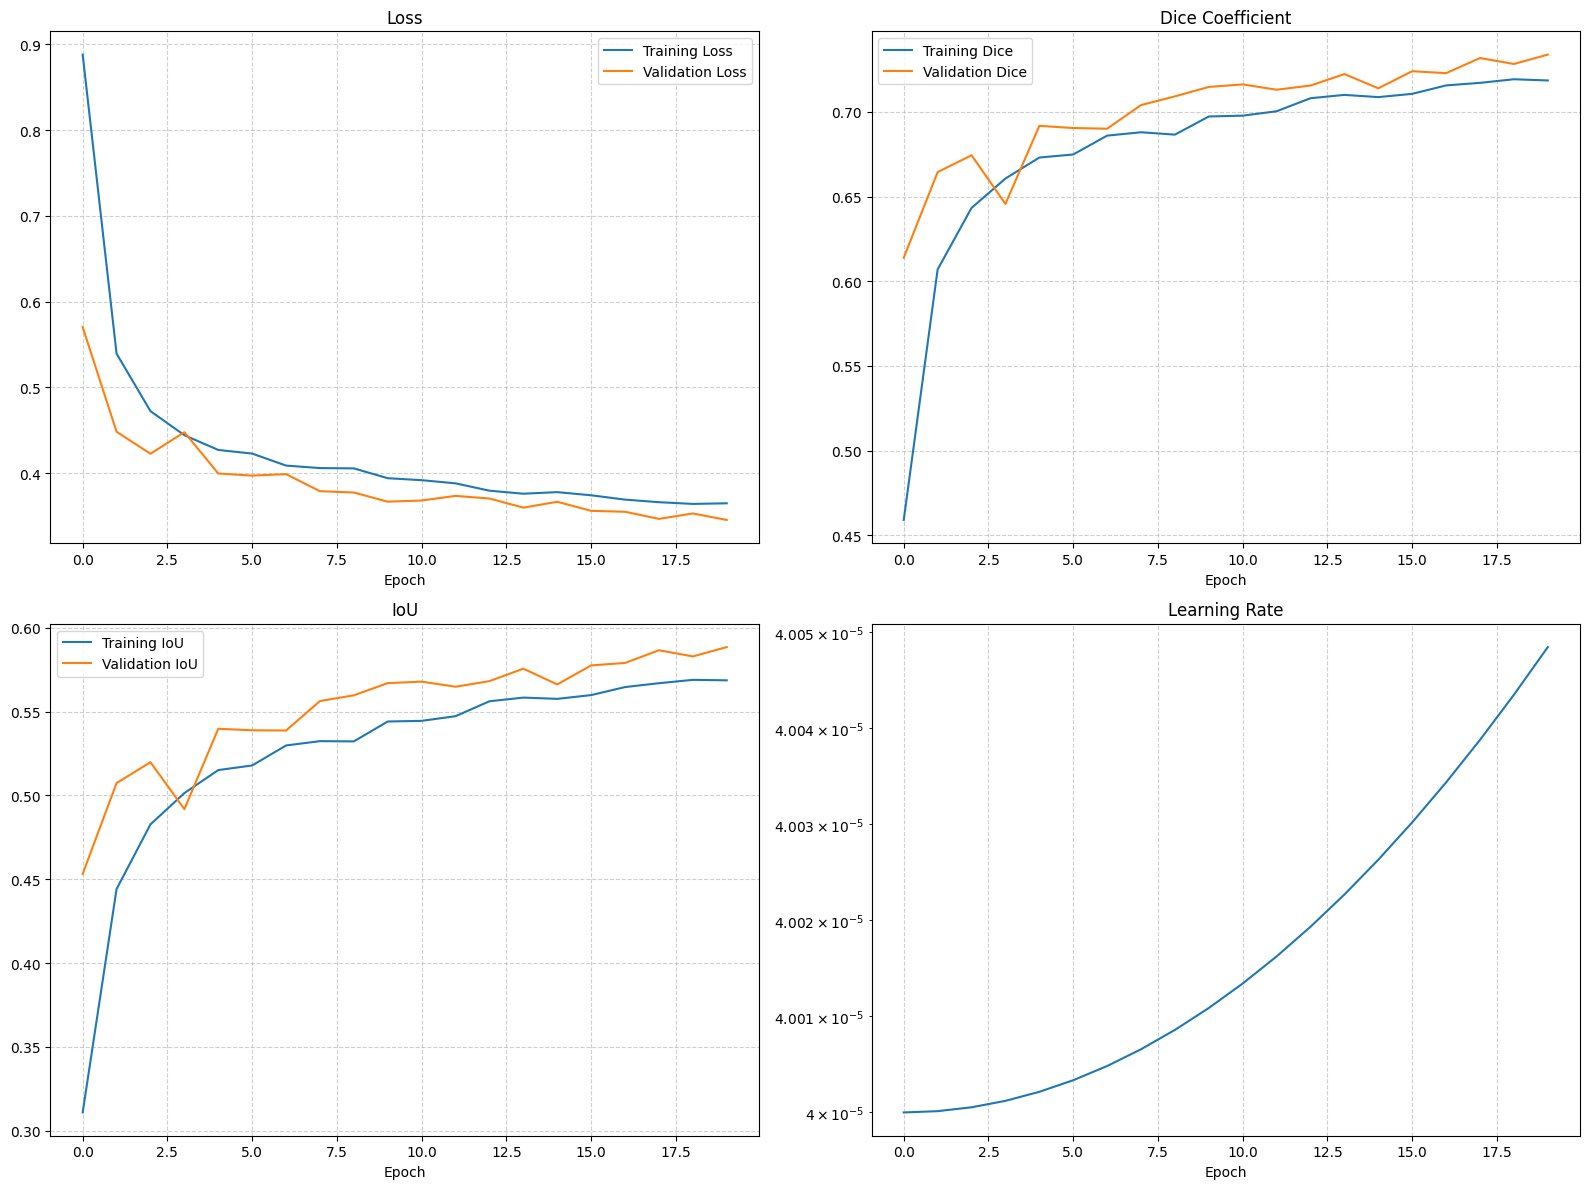

In [37]:
# Plot training history
plot_training_history(history)

## 11. Loading Best Model for Evaluation

In [5]:
# Load the best model weights
model.load_state_dict(torch.load('./models/best_unet_resnet34.pth')) #It should be changed to DeepLabV3Plus
model.eval()  # Set model to evaluation mode

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

## 12. Evaluating on Validation Set

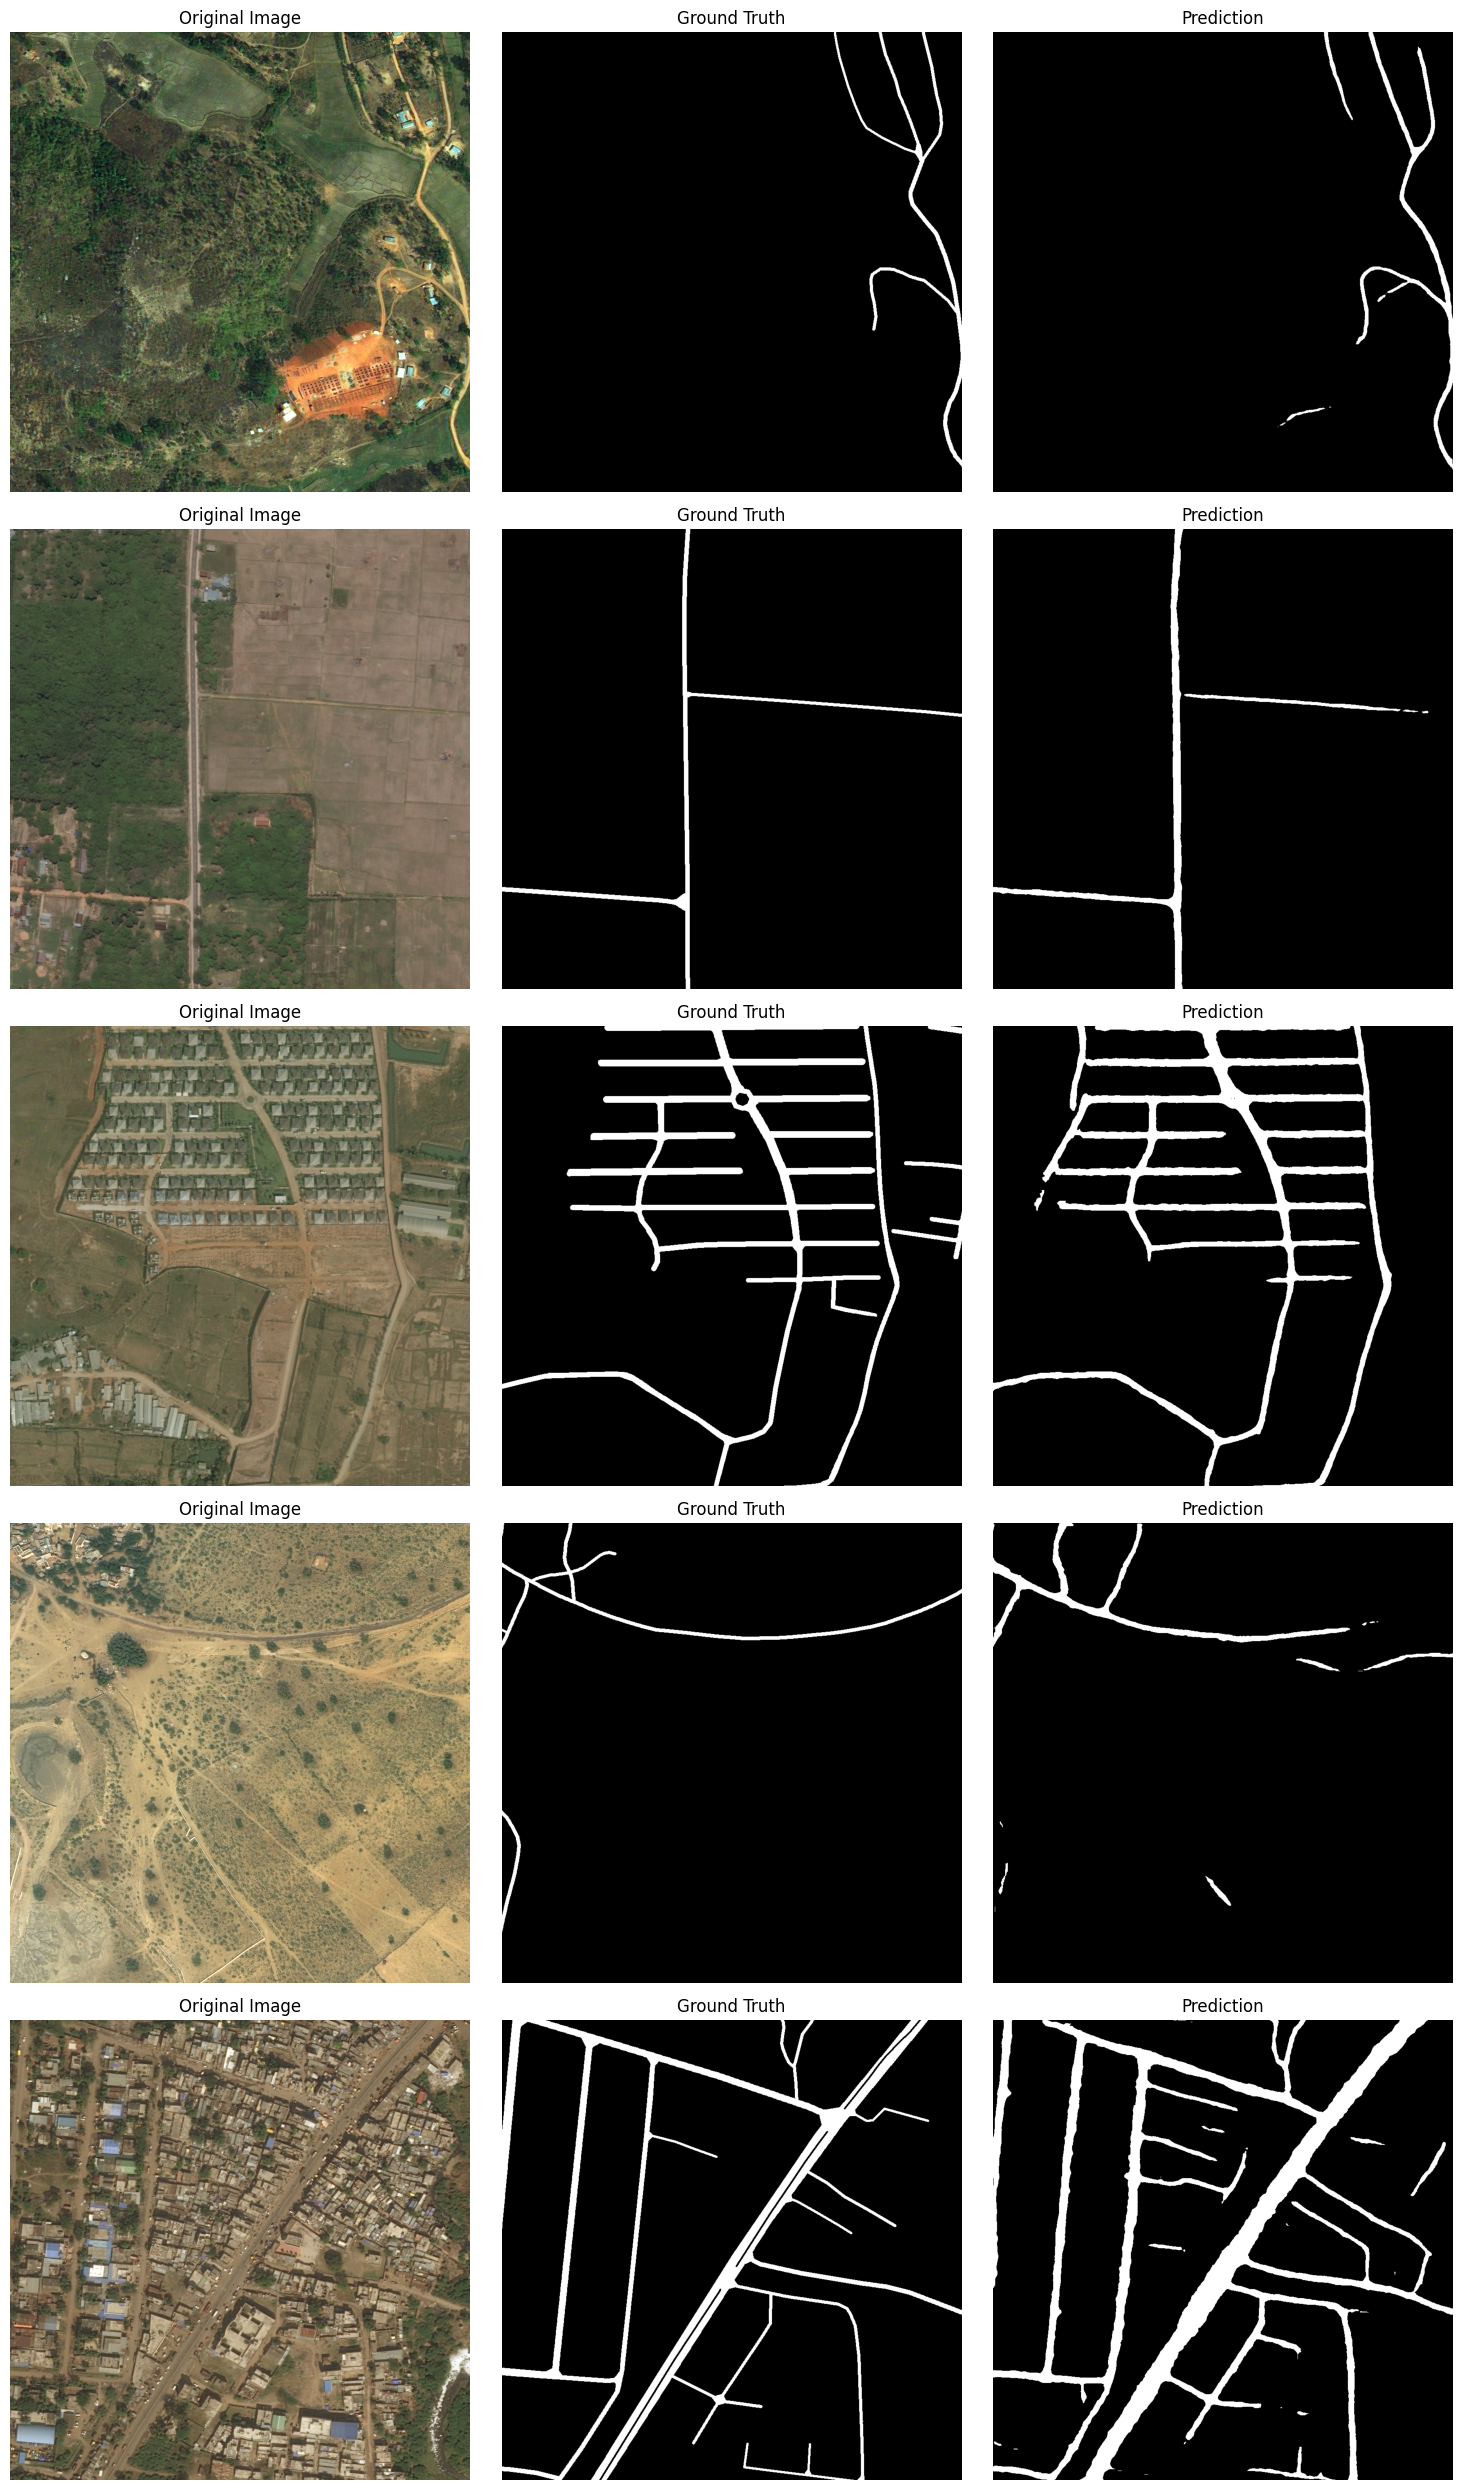

In [9]:
# Create a dataset for visualization (with preprocessing but no augmentation)
vis_dataset = RoadsDataset(
    valid_df,
    augmentation=None,
    preprocessing=get_preprocessing()
)

# Plot predictions on random samples
plot_predictions_with_raw_images(model, vis_dataset, valid_df, device, num_samples=5, threshold=0.5)

## 13. Quantitative Evaluation

In [44]:
# Evaluate the model quantitatively on validation set
model.eval()
val_dice_scores = []
val_iou_scores = []

with torch.no_grad():
    for images, masks in valid_loader:
        images = images.to(device)
        masks = masks.to(device).float().unsqueeze(1)  # Add channel dimension

        outputs = model(images)

        batch_dice = dice_coefficient(outputs, masks)
        batch_iou = iou_score(outputs, masks)

        val_dice_scores.append(batch_dice)
        val_iou_scores.append(batch_iou)

# Calculate average metrics
mean_dice = np.mean(val_dice_scores)
mean_iou = np.mean(val_iou_scores)

print(f"Validation Dice Coefficient: {mean_dice:.4f}")
print(f"Validation IoU Score: {mean_iou:.4f}")

Validation Dice Coefficient: 0.7338
Validation IoU Score: 0.5884
